### **<모듈 임포트>**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!git clone https://github.com/dorabangs/ant_bee.git

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
%matplotlib inline

#### **<GPU 확인, 사용할 device 설정>**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### **<Seed/Random state 고정, 재현성을 위해>**

In [3]:
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

#### **<데이터 불러오기>**
#### 개미와 벌 분류하기
#### train data class당 대략 120개
#### validatation data class당 대략 70~80개

In [4]:
data_transforms = {
    'train':transforms.Compose([ # Composes several transforms together.
        transforms.RandomResizedCrop(224), # size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # Sequence of means for each channel, Sequence of standard deviations for each channel.
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = "/content/ant_bee/ant_bee"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

### **<pretrained VGG16 모델 불러오기>**

In [6]:
vgg16 = models.vgg16(pretrained=True)

In [7]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### **<fine-tuning : 마지막 Linear layer>**

In [8]:
for param in vgg16.parameters():
    param.requires_grad = False

In [9]:
num_in = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_in,2)

In [10]:
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier[-1].parameters(), 
                      lr=0.001, 
                      momentum=0.9)
cus_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=5,
                                       gamma=0.1)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # channel, height, width -> height, width, channel
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Given an interval, values outside the interval are clipped to the interval edges.
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('real: {} | predicted: {}'.format(class_names[labels[j]],
                                                               class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
vgg16_ft = train_model(vgg16, criterion, optimizer, 
                       cus_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.2756 Acc: 0.8566
val Loss: 0.1170 Acc: 0.9542

Epoch 2/25
----------
train Loss: 0.2090 Acc: 0.9303
val Loss: 0.1768 Acc: 0.9608

Epoch 3/25
----------
train Loss: 0.1661 Acc: 0.9303
val Loss: 0.1518 Acc: 0.9412

Epoch 4/25
----------
train Loss: 0.2468 Acc: 0.9303
val Loss: 0.1207 Acc: 0.9542

Epoch 5/25
----------
train Loss: 0.1179 Acc: 0.9590
val Loss: 0.1204 Acc: 0.9608

Epoch 6/25
----------
train Loss: 0.0888 Acc: 0.9631
val Loss: 0.1145 Acc: 0.9542

Epoch 7/25
----------
train Loss: 0.0928 Acc: 0.9631
val Loss: 0.1128 Acc: 0.9608

Epoch 8/25
----------
train Loss: 0.0837 Acc: 0.9713
val Loss: 0.1065 Acc: 0.9608

Epoch 9/25
----------
train Loss: 0.0993 Acc: 0.9549
val Loss: 0.1017 Acc: 0.9608

Epoch 10/25
----------
train Loss: 0.1374 Acc: 0.9467
val Loss: 0.1017 Acc: 0.9608

Epoch 11/25
----------
train Loss: 0.1026 Acc: 0.9590
val Loss: 0.1015 Acc: 0.9608

Epoch 12/25
----------
train Loss: 0.1707 Acc: 0.9385
val Loss: 0.1009 Acc: 0.9608

E

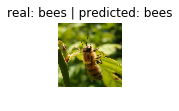

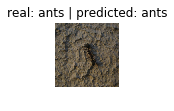

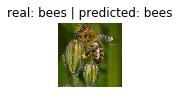

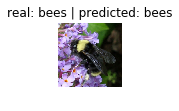

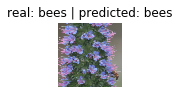

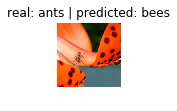

In [15]:
visualize_model(vgg16_ft)